Testing RMSE: 0.9103761753253437
Testing MAE: 0.7130340000000006
Testing MAPE: 0.06325977471968638


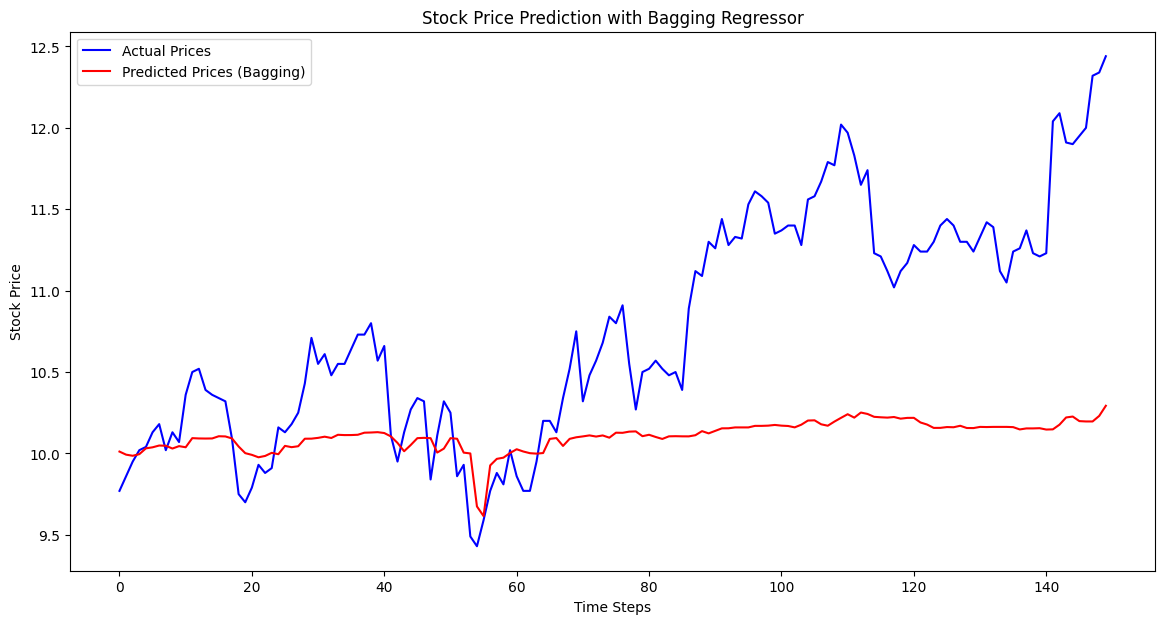

In [3]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('HPG Historical Data.csv', sep=",")
df1 = df.reset_index()['Price']

# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:]

# 5. Hàm Create Dataset (convert an array of values into a dataset matrix)
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

# 7. Định nghĩa DecisionTree model
def create_DecisionTree_model():
    model = DecisionTreeRegressor()
    return model

# Create and train multiple decision tree models
n_estimators = 10
predictions = []

for _ in range(n_estimators):
    base_model = create_DecisionTree_model()
    bagging_model = BaggingRegressor(base_model, n_estimators=100, random_state=42)
    bagging_model.fit(X_train, y_train)
    y_pred = bagging_model.predict(X_test)
    predictions.append(y_pred.flatten())

# Average the predictions
bagging_predictions = np.mean(predictions, axis=0)

# Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
bagging_predictions_inv = scaler.inverse_transform(bagging_predictions.reshape(-1, 1))

# 8. Dự đoán và đánh giá mô hình
rmse_testing = np.sqrt(mean_squared_error(y_test_inv, bagging_predictions_inv))
mae_testing = mean_absolute_error(y_test_inv, bagging_predictions_inv)
mape_testing = mean_absolute_percentage_error(y_test_inv, bagging_predictions_inv)

print(f'Testing RMSE: {rmse_testing}')
print(f'Testing MAE: {mae_testing}')
print(f'Testing MAPE: {mape_testing}')

# 9. Trực quan hóa kết quả
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Prices', color='blue')
plt.plot(bagging_predictions_inv, label='Predicted Prices (Bagging)', color='red')
plt.title('Stock Price Prediction with Bagging Regressor')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
